In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/samples.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


### Get set of patients

In [2]:
def get_TARGET(x):
    if 'TARGET' in x:
        return True
    else:
        return False
def get_origin(x):
    return int(x.split('-')[3][:2])

uuid_barcode_map = pd.read_csv('/cellar/users/andreabc/GDC_barcodes/uuid_barcode_map.txt', sep='\t')

# only exome
uuid_barcode_map = uuid_barcode_map[uuid_barcode_map.type == 'aligned_reads']
# remove target
uuid_barcode_map['TARGET'] = uuid_barcode_map.sample_barcode.apply(get_TARGET)
uuid_barcode_map = uuid_barcode_map[~uuid_barcode_map['TARGET']]

uuid_barcode_map['origin'] = uuid_barcode_map.sample_barcode.apply(get_origin)
uuid_barcode_map = uuid_barcode_map[uuid_barcode_map.origin.isin([10, 11])]

uuid_barcode_map = uuid_barcode_map.drop_duplicates('barcode')

In [3]:
samples = list(uuid_barcode_map.file_id)
barcodes = list(uuid_barcode_map.barcode)
file_names = list(uuid_barcode_map.file_name)
out_dirs = ['/nrnb/users/ramarty/TCGA/exomes/{0}'.format(x) for x in barcodes]

In [4]:
len(samples), len(barcodes), len(out_dirs)

(10505, 10505, 10505)

In [5]:
out_dirs[:3]

['/nrnb/users/ramarty/TCGA/exomes/TCGA-BP-4967',
 '/nrnb/users/ramarty/TCGA/exomes/TCGA-TM-A84O',
 '/nrnb/users/ramarty/TCGA/exomes/TCGA-BF-AAP2']

In [6]:
output = [x for x in open('/cellar/users/ramarty/Data/kir/scratch/patients_with_chr19.bam').readlines()]

valid_barcodes = []
for x in output:
    try:
        valid_barcodes.append(x.split(' ')[10][:12])
    except:
        None

barcodes = valid_barcodes
out_dirs = ['/nrnb/users/ramarty/TCGA/exomes/{0}'.format(x) for x in barcodes]

In [7]:
len(barcodes), len(out_dirs)

(6408, 6408)

In [8]:
barcodes[:10]

['TCGA-02-0003',
 'TCGA-02-0033',
 'TCGA-02-0047',
 'TCGA-02-0055',
 'TCGA-02-2466',
 'TCGA-02-2470',
 'TCGA-02-2483',
 'TCGA-02-2485',
 'TCGA-02-2486',
 'TCGA-04-1331']

### Create cluster script

In [16]:
def create_cluster_script_download(barcodes, out_dirs):

    new_script_file = '/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/tcga/run_PING.sh'

    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/kir/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/kir/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        out_file.write("#$ -t 1-{0}\n".format(len(barcodes)))
        #out_file.write("#$ -t 1-10\n".format(len(barcodes)))
        out_file.write("#$ -l h_vmem=3G\n")
        out_file.write("#$ -tc 5\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set barcodes=({0})\n".format(" ".join(barcodes)))
        out_file.write("set outs=({0})\n".format(" ".join(out_dirs)))
        out_file.write("\n")

        out_file.write("set barcode=$barcodes[$SGE_TASK_ID]\n")
        out_file.write("set out=$outs[$SGE_TASK_ID]\n")

        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("echo $barcode\n")
        
        # Make directory
        out_file.write("mkdir $out\n")
        out_file.write("mkdir $out/PING\n")
        out_file.write("mkdir /tmp/ramarty\n")
        out_file.write("mkdir /tmp/ramarty/$barcode\n")
        out_file.write("echo Directories created.\n")
        
        # Pre-processing data
        out_file.write("python /cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/convert_to_fastqTWO.py " + \
                       "$out/chr19.bam /tmp/ramarty/$barcode/chr19_sorted /tmp/ramarty/$barcode/chr19_dedup " + \
                       "$out/PING_sequences/_full_exome_1.fastq $out/PING_sequences/_full_exome_2.fastq cellar\n")
        out_file.write("echo python /cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/convert_to_fastqTWO.py " + \
                       "$out/chr19.bam /tmp/ramarty/$barcode/chr19_sorted /tmp/ramarty/$barcode/chr19_dedup " + \
                       "$out/PING_sequences/full_exome_1.fastq $out/PING_sequences/full_exome_2.fastq cellar\n")
        out_file.write("echo Pre-processing complete.\n")
        out_file.write("\n")
        
        # Ping: step 1
        out_file.write("cd /nrnb/users/ramarty/programs/PING\n")
        out_file.write("Rscript --vanilla " + \
                       "/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/runPING_extractor.R " + \
                       "$out/PING_sequences/ full_exome_1.fastq full_exome_2.fastq $out/PING_sequences/ 4\n")
        out_file.write("echo Rscript --vanilla " + \
                       "/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/runPING_extractor.R " + \
                       "$out/PING_sequences/ full_exome_1.fastq full_exome_2.fastq $out/PING_sequences/ 4\n")
        
        # Ping: step 2
        out_file.write("Rscript --vanilla " + \
                       "/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/runPING_gc_caller.R " + \
                       "$out/PING_sequences/  $out/PING/ 40000\n")
        out_file.write("echo Rscript --vanilla " + \
                       "/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/runPING_gc_caller.R " + \
                       "$out/PING_sequences/  $out/PING/ 40000\n")
        
        # Clean up
        out_file.write("rm -r /tmp/ramarty/$barcode\n")
        out_file.write("date\n")

In [17]:
create_cluster_script_download(['TCGA-02-2483'], ['/nrnb/users/ramarty/TCGA/exomes/TCGA-02-2483/'])

In [18]:
create_cluster_script_download(barcodes, out_dirs)

### Collect output <br>

In [9]:
barcodes, success, indices = [], [], []
for i in range(1, 6408):
    lines = open('/cellar/users/ramarty/Data/kir/sge-system_files/run_PING.sh.o427297.{0}'.format(str(i))).readlines()
    barcodes.append(lines[4].strip())
    if 'Finished! Please look at MIRA_results.csv.\n' in lines:
        success.append(True)
    else:
        success.append(False)
    indices.append(i)

KeyboardInterrupt: 

In [ ]:
output = pd.DataFrame({'Barcode': barcodes,
                         'Typed': success,
                          'Index': indices})

In [ ]:
output.Typed.value_counts()

In [ ]:
output.head()

Get speeds

In [ ]:
lines = open('/cellar/users/ramarty/Data/kir/sge-system_files/run_PING.sh.o427297.{0}'.format(str(438))).readlines()

x = np.asarray([float(j) for j in lines[2].split(' ')[3].split(':')])

y = np.asarray([float(j) for j in lines[-1].split(' ')[3].split(':')])

t = np.subtract(y, x)

s = t[0]*3600 + t[1]*60 + t[2]

In [7]:
x, y

(array([20., 59., 18.]), array([21.,  5., 54.]))

In [8]:
t

array([  1., -54.,  36.])

In [9]:
s

396.0

In [10]:
times, barcodes, indices = [], [], []
for i, barcode in zip(output[output.Typed].Index, output[output.Typed].Barcode):
    lines = open('/cellar/users/ramarty/Data/kir/sge-system_files/run_PING.sh.o427297.{0}'.format(str(i))).readlines()

    x = np.asarray([float(j) for j in lines[2].split(' ')[3].split(':')])
    y = np.asarray([float(j) for j in lines[-1].split(' ')[3].split(':')])

    t = np.subtract(y, x)
    s = t[0]*3600 + t[1]*60 + t[2]
    
    times.append(s)
    barcodes.append(barcode)
    indices.append(i)

In [11]:
ping_timing = pd.DataFrame({'Barcode': barcodes,
                           'Time': times,
                           'Index': indices})

In [12]:
ping_timing.Time.describe()

count     154.000000
mean      275.331169
std       115.757977
min        87.000000
25%       202.500000
50%       243.000000
75%       323.250000
max      1050.000000
Name: Time, dtype: float64

In [127]:
ping_timing.to_csv('/cellar/users/ramarty/Data/kir/validation/PING/run_time.csv')

In [2]:
ping_timing = pd.read_csv('/cellar/users/ramarty/Data/kir/validation/PING/run_time.csv', index_col=0)

### Get timing for same patients with KIRcount

In [154]:
def create_cluster_script_gather(barcodes, out_dirs):

    new_script_file = '/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/tcga/gather_components.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/kir/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/kir/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        out_file.write("#$ -t 1-{0}\n".format(len(barcodes)))
        #out_file.write("#$ -t 1-2\n".format(len(barcodes)))
        out_file.write("#$ -l h_vmem=2G\n")
        out_file.write("#$ -tc 5\n")
        out_file.write("#$ -pe smp 8\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set barcodes=({0})\n".format(" ".join(barcodes)))
        out_file.write("set outs=({0})\n".format(" ".join(out_dirs)))
        out_file.write("\n")

        out_file.write("set barcode=$barcodes[$SGE_TASK_ID]\n")
        out_file.write("set out=$outs[$SGE_TASK_ID]\n")
        out_file.write("\n")

        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("echo $barcode\n")
        out_file.write("\n")
        
        # Make directories
        out_file.write("mkdir $out/features\n")
        out_file.write("\n")
        
        # Strip fastq - just import chr19 instead. That would be comparable.
        out_file.write("python /cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/convert_to_fastq2.py " + \
                       "$out/chr19.bam $out/KIR_sorted " + \
                       "$out/KIR_dedup $out/KIR_and_unmapped.fastq cellar\n")
        out_file.write("echo Fastq stripped.\n")
        out_file.write("\n")
        
        # Map to reference
        out_file.write("python /cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/map_to_reference.py " + \
                       "$out/KIR_and_unmapped.fastq $out/KIR_and_unmapped.aligned.test.bam " + \
                       "/cellar/users/ramarty/Data/kir/ref/all_alleles_and_random cellar\n")
        out_file.write("echo Mapped to KIR.\n")
        out_file.write("\n")
        
        # Strip reads from KIR bam
        out_file.write("python /cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/convert_to_fastq2.py " + \
                       "$out/KIR_and_unmapped.aligned.test.bam $out/KIR_sorted $out/KIR_dedup " + \
                       "$out/KIR_and_unmapped.aligned.fastq cellar\n")
        out_file.write("echo Stripped reads.\n")
        out_file.write("\n")
        
        # Collect components        
        out_file.write("python /cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/bin/component_collection.py " + \
                       "$out/KIR_and_unmapped.aligned.fastq $out/features " + \
                       "/cellar/users/ramarty/Data/kir/kmers/kmer_groups/kir_four_random.txt " + \
                       "kir_four_random\n")
        out_file.write("echo Components gathered - KIR.\n")
        out_file.write("\n")
        
        # Clean up
        out_file.write("rm $out/KIR_sorted\n")
        out_file.write("rm $out/KIR_dedup\n")
        out_file.write("rm $out/*fastq\n")
        out_file.write("date\n")

In [12]:
barcodes = list(ping_timing.Barcode)
out_dirs = ['/nrnb/users/ramarty/TCGA/exomes/{0}'.format(x) for x in barcodes]

In [156]:
create_cluster_script_gather(barcodes, out_dirs)

In [3]:
times, barcodes, indices = [], [], []
for i, barcode in enumerate(list(ping_timing.Barcode)):
    lines = open('/cellar/users/ramarty/Data/kir/sge-system_files/gather_components.sh.o427863.{0}'.format(str(i+1))).readlines()

    x = np.asarray([float(j) for j in lines[2].split(' ')[3].split(':')])
    y = np.asarray([float(j) for j in lines[-1].split(' ')[3].split(':')])

    t = np.subtract(y, x)
    s = t[0]*3600 + t[1]*60 + t[2]
    
    times.append(s)
    barcodes.append(barcode)
    indices.append(i+1)

In [4]:
kircount_timing = pd.DataFrame({'Barcode': barcodes,
                           'Time': times,
                           'Index': indices})

In [5]:
kircount_timing.Time.describe()

count    154.000000
mean      65.337662
std       29.413487
min       24.000000
25%       45.000000
50%       55.000000
75%       80.000000
max      198.000000
Name: Time, dtype: float64

Plot the difference in timing

In [6]:
kircount_timing.head()

,Barcode,Index,Time
0,TCGA-02-0033,1,93.0
1,TCGA-02-0047,2,94.0
2,TCGA-06-0185,3,84.0
3,TCGA-06-0221,4,138.0
4,TCGA-06-0876,5,129.0


In [7]:
ping_timing.head()

,Barcode,Index,Time
0,TCGA-02-0033,2,399.0
1,TCGA-02-0047,3,272.0
2,TCGA-06-0185,72,201.0
3,TCGA-06-0221,83,321.0
4,TCGA-06-0876,98,494.0


In [8]:
kircount_timing['KIRcount'] = kircount_timing.Time
ping_timing['PING'] = ping_timing.Time

In [9]:
comparison = pd.merge(kircount_timing.loc[:, ['Barcode', 'KIRcount']],
        ping_timing.loc[:, ['Barcode', 'PING']], on='Barcode', how='inner')

In [10]:
comparison.describe()

,KIRcount,PING
count,154.000000,154.000000
mean,65.337662,275.331169
std,29.413487,115.757977
min,24.000000,87.000000
25%,45.000000,202.500000
50%,55.000000,243.000000
75%,80.000000,323.250000
max,198.000000,1050.000000


(0, 1100)

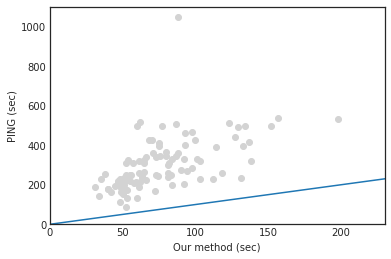

In [24]:
plt.scatter(comparison.KIRcount[:100], comparison.PING[:100], color='lightgrey')
plt.ylabel('PING (sec)')
plt.xlabel('Our method (sec)')
plt.plot((0, 1100), (0, 1100))
plt.xlim(0, 230)
plt.ylim(0, 1100)

### Comparison of copy number

In [116]:
types = pd.read_csv('/cellar/users/ramarty/Data/kir/TCGA/data_frames/TCGA.gene_copy_numbers.kir_mean.csv',
                    index_col=0)

In [117]:
shortened_types = [x[3:] for x in types.columns]

In [118]:
types.columns = shortened_types

In [119]:
genes = ['2DL1', '2DS1', '2DL4', '2DP1', '2DS2', '2DS3', '2DS4', '2DS5', '3DL1', '3DL2', '3DL3', '3DP1','3DS1']

In [120]:
types = types.loc[:, genes]

In [121]:
ping = pd.read_csv('/cellar/users/ramarty/Data/kir/validation/PING/results.csv', index_col=0)

In [122]:
ping = ping.loc[:, genes]

In [140]:
patients = [x for x in ping.index if x in types.index]
len(patients)

97

In [124]:
ping = ping.loc[patients]
types = types.loc[patients]

In [141]:
len(ping), len(types)

(97, 97)

In [143]:
len(ping.dropna()), len(types.dropna())

(97, 97)

In [125]:
ping.head()

,2DL1,2DS1,2DL4,2DP1,2DS2,2DS3,2DS4,2DS5,3DL1,3DL2,3DL3,3DP1,3DS1
TCGA-02-0033,1,1,1,1,1,0,1,0,1,2,2,2,0
TCGA-02-0047,1,0,2,1,1,0,1,0,2,2,2,2,0
TCGA-06-0185,1,0,2,2,0,0,1,0,2,2,2,2,0
TCGA-06-0876,1,1,2,2,1,0,1,0,1,2,2,2,1
TCGA-06-0877,1,1,2,1,2,1,1,0,1,2,2,3,1


In [126]:
types.head()

,2DL1,2DS1,2DL4,2DP1,2DS2,2DS3,2DS4,2DS5,3DL1,3DL2,3DL3,3DP1,3DS1
TCGA-02-0033,1,0,1,1,1,0,1,1,1,2,2,1,0
TCGA-02-0047,1,0,2,1,1,0,2,0,2,2,2,2,0
TCGA-06-0185,2,0,2,2,0,0,2,0,2,2,2,2,0
TCGA-06-0876,1,1,2,1,1,0,1,1,1,2,2,2,1
TCGA-06-0877,1,1,2,1,1,1,1,1,1,2,2,2,1


In [147]:
agreement = []
for gene in genes:
    print gene, (ping.loc[:, gene] == types.loc[:, gene]).mean()
    agreement.append((ping.loc[:, gene] == types.loc[:, gene]).mean())

2DL1 0.6907216494845361
2DS1 0.8762886597938144
2DL4 0.8041237113402062
2DP1 0.8350515463917526
2DS2 0.8865979381443299
2DS3 0.8144329896907216
2DS4 0.35051546391752575
2DS5 0.7422680412371134
3DL1 0.8762886597938144
3DL2 0.9072164948453608
3DL3 0.8969072164948454
3DP1 0.41237113402061853
3DS1 0.865979381443299


In [148]:
agreement_df = pd.DataFrame({'Gene': genes,
                            'Agreement': agreement})

Text(0,0.5,'Percentage of patients where PING\nand our method agreed on copy number')

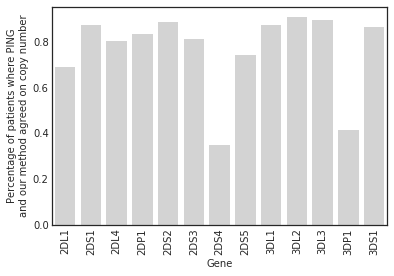

In [159]:
sns.barplot(x='Gene', y='Agreement', data=agreement_df, color='lightgrey')
plt.xticks(rotation=90)
plt.ylabel('Percentage of patients where PING\nand our method agreed on copy number')

In [164]:
for gene in genes:
    print gene, ping.loc[:, gene].mean()/2, types.loc[:, gene].mean()/2

2DL1 0.685567010309 0.855670103093
2DS1 0.139175257732 0.159793814433
2DL4 0.90206185567 1.01030927835
2DP1 0.850515463918 0.860824742268
2DS2 0.30412371134 0.268041237113
2DS3 0.0360824742268 0.134020618557
2DS4 0.515463917526 0.865979381443
2DS5 0.0103092783505 0.144329896907
3DL1 0.840206185567 0.865979381443
3DL2 1.0 1.04639175258
3DL3 1.0 1.0412371134
3DP1 1.24226804124 1.0206185567
3DS1 0.113402061856 0.159793814433


In [138]:
for gene in genes:
    print gene
    print ping.loc[:, gene].value_counts(), types.loc[:, gene].value_counts()

2DL1
1    53
2    40
0     4
Name: 2DL1, dtype: int64 2    61
1    26
3     6
0     4
Name: 2DL1, dtype: int64
2DS1
0    70
1    27
Name: 2DS1, dtype: int64 0    67
1    29
2     1
Name: 2DS1, dtype: int64
2DL4
2    78
1    19
Name: 2DL4, dtype: int64 2    91
3     4
1     2
Name: 2DL4, dtype: int64
2DP1
2    68
1    29
Name: 2DP1, dtype: int64 2    64
1    24
3     5
0     4
Name: 2DP1, dtype: int64
2DS2
0    46
1    43
2     8
Name: 2DS2, dtype: int64 0    48
1    46
2     3
Name: 2DS2, dtype: int64
2DS3
0    90
1     7
Name: 2DS3, dtype: int64 0    73
1    22
2     2
Name: 2DS3, dtype: int64
2DS4
1    92
2     4
0     1
Name: 2DS4, dtype: int64 2    62
1    29
3     5
0     1
Name: 2DS4, dtype: int64
2DS5
0    95
1     2
Name: 2DS5, dtype: int64 0    70
1    26
2     1
Name: 2DS5, dtype: int64
3DL1
2    57
1    34
3     5
0     1
Name: 3DL1, dtype: int64 2    62
1    29
3     5
0     1
Name: 3DL1, dtype: int64
3DL2
2    97
Name: 3DL2, dtype: int64 2    88
3     9
Name: 3DL2, dtype: 